# Projet

### Imports

In [17]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets
import matplotlib.pyplot as plt
import numpy
from sklearn.cluster import KMeans

## 1. Collecte de données

### Dataframe Functions

In [4]:
def jsonToDataframe(path):   
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def dataframeToJson(path, dataframe):   
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### Récupération du résultat d'une query Wikidata

In [5]:
size = 5
dataPath = "data.json"
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()

# On normalise les résultat pour pandas
array = []
for data in results["results"]["bindings"]:
    name = data["itemLabel"]["value"]
    format = data["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"

    array.append([name,  
                  data["pic"]["value"], 
                  data["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument']])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags"])

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)

# Nettoyage du dossier /images
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)



dataframe


,label,link,entityID,format,path,size,sizeCategory,tags
0,National Monument on Dam Square,http://commons.wikimedia.org/wiki/Special:File...,Q473851,jpg,./images/National Monument on Dam Square.jpg,(),None,[#monument]
1,Praileaitz Cave,http://commons.wikimedia.org/wiki/Special:File...,Q478482,jpg,./images/Praileaitz Cave.jpg,(),None,[#monument]
2,Praileaitz Cave,http://commons.wikimedia.org/wiki/Special:File...,Q478482,jpg,./images/Praileaitz Cave.jpg,(),None,[#monument]
3,Collegiate church of San Pedro de Cervatos,http://commons.wikimedia.org/wiki/Special:File...,Q478585,jpg,./images/Collegiate church of San Pedro de Cer...,(),None,[#monument]
4,Samjeondo Monument,http://commons.wikimedia.org/wiki/Special:File...,Q497146,JPG,./images/Samjeondo Monument.JPG,(),None,[#monument]


### Téléchargement des Images

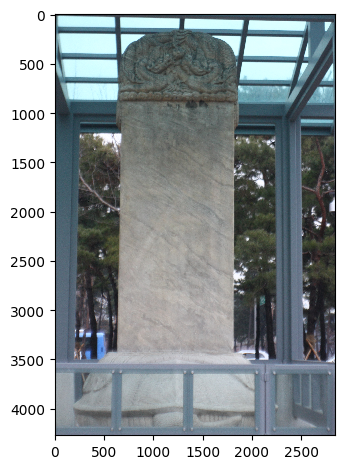

In [6]:
dataframe = jsonToDataframe(dataPath)
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [7]:
dataframe = jsonToDataframe(dataPath)

wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "dateTaken", 'appareil']

for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcours les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)
        
dataframe 

,label,link,entityID,format,path,size,sizeCategory,tags,orientation,artist,dateTaken,appareil
0,National Monument on Dam Square,http://commons.wikimedia.org/wiki/Special:File...,Q473851,jpg,./images/National Monument on Dam Square.jpg,"(3038, 3083)",NaN,[#monument],0,None,None,None
1,Praileaitz Cave,http://commons.wikimedia.org/wiki/Special:File...,Q478482,jpg,./images/Praileaitz Cave.jpg,"(4000, 3000)",NaN,[#monument],1,None,2023:08:06 14:13:30,V2023
2,Praileaitz Cave,http://commons.wikimedia.org/wiki/Special:File...,Q478482,jpg,./images/Praileaitz Cave.jpg,"(4000, 3000)",NaN,[#monument],1,None,2023:08:06 14:13:30,V2023
3,Collegiate church of San Pedro de Cervatos,http://commons.wikimedia.org/wiki/Special:File...,Q478585,jpg,./images/Collegiate church of San Pedro de Cer...,"(1956, 1077)",NaN,[#monument],1,None,None,None
4,Samjeondo Monument,http://commons.wikimedia.org/wiki/Special:File...,Q497146,JPG,./images/Samjeondo Monument.JPG,"(2848, 4272)",NaN,[#monument],0,None,2010:12:19 17:24:59,Canon EOS 450D


## Analyse des Données

In [8]:
# Création de la dataframe des utilisateurs
usersPath = 'users.json'

array = [['default',[]]]
usersDataframe = pandas.DataFrame(array, columns=['username', 'likedImages'])

dataframeToJson(usersPath, usersDataframe)

usersDataframe

,username,likedImages
0,default,[]


## Test Interaction

In [9]:
images = glob.glob('./images/*')
images

['./images\\Collegiate church of San Pedro de Cervatos.jpg',
 './images\\National Monument on Dam Square.jpg',
 './images\\Praileaitz Cave.jpg',
 './images\\Samjeondo Monument.JPG']

In [10]:
layout =  ipywidgets.GridspecLayout(n_columns=3, n_rows=len(images), height='400px')

children = [[],[]]
for i, img in enumerate(images):
  with open(img, "rb") as f :
    img = f.read()

    layout = ipywidgets.widgets.Layout(display = 'flex')
    imageLayout = ipywidgets.widgets.Layout(display = 'flex', width = '75%')
    checkBoxLayout = ipywidgets.widgets.Layout(display = 'flex')
    checkBox = ipywidgets.Checkbox(layout = checkBoxLayout)
    
    ImageBox = ipywidgets.Box([ipywidgets.widgets.Image(value=img, layout = imageLayout),checkBox], layout = layout)
    children[i%2].append(ImageBox)

# Customize your layout here:
box_layout = ipywidgets.widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    width='50%')

# Create the widget
box1 = ipywidgets.widgets.Box(layout = box_layout)
box1.children = children[0]
box2 = ipywidgets.widgets.Box(layout = box_layout)
box2.children = children[1]

ipywidgets.HBox([box1,box2])

## Visualisation des Données

<BarContainer object of 3 artists>

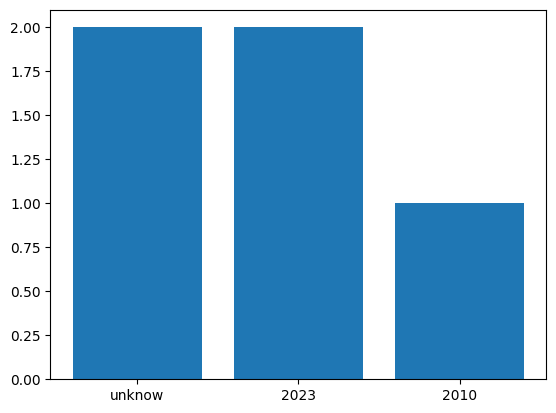

In [11]:
dataframe = jsonToDataframe(dataPath)

sources = {'year':'dateTaken', 'orientation':'orientation'}
criteria = ''
while criteria not in sources :
    criteria = input('criteria :')


categories = ['unknow']
cardinals  = [0]


for i in range(len(dataframe.index)):
    value = str(dataframe._get_value(i, sources[criteria]))

    if value != 'None':
        if criteria == 'year':
            value = value.split(':')[0].strip()
        elif criteria == 'orientation':
            value = {'0':"Portrait", '1':"Landscape"}[value]

        if value in categories:
            cardinals[categories.index(value)] += 1
        else:
            categories.append(value)
            cardinals.append(1)
    else:
        cardinals[0] += 1


plt.bar(categories, cardinals)

## Kmeans et Couleurs dominantes

[0.26830617 0.39287491 0.23461463 0.10420429]


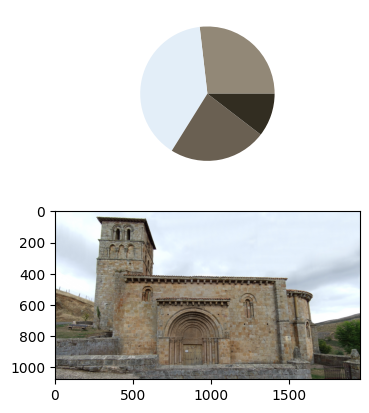

In [54]:
dataframe = jsonToDataframe(dataPath)
imagePaths = glob.glob('./images/*')

nColors = 4

imagePaths = [imagePaths[0]]

kmeans = KMeans(n_clusters=nColors, random_state=0, n_init="auto")

fig, ax = plt.subplots(len(imagePaths),2)

for i, path in enumerate(imagePaths):
    img = PIL.Image.open(path).convert('RGB')
    pixelData = numpy.array(img).reshape(-1, 3)
    kmeans.fit(pixelData)

    proportions = numpy.array([0 for i in range(nColors)])
    for x in kmeans.labels_:
        proportions[x] += numpy.float64(1)
    proportions = proportions / kmeans.labels_.size
    print(proportions)
    
    ax[0].pie(proportions, colors=(kmeans.cluster_centers_/255))
    ax[1].imshow(img)





